In [2]:
# Install CatBoost and any other missing libraries
!pip install catboost
!pip install dask[dataframe]  # Resolves the warning about Dask if necessary


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 23.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 7.1 MB/s eta 0:00:00


###Cell 1: Import Libraries


In [3]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')  # To ignore unnecessary warnings


###Cell 2: Load and Explore Data


In [ ]:
# Cell 2: Load and Explore Data
data = pd.read_csv('/content/drive/MyDrive/Car_Pricee/used_car_dataset.csv')  
print("Data Sample:\n", data.head())
print("\nData Information:\n")
print(data.info())


Data Sample:
            Brand      model  Year  Age     kmDriven Transmission   Owner  \
0          Honda       City  2001   23    98,000 km       Manual  second   
1         Toyota     Innova  2009   15  190000.0 km       Manual  second   
2     Volkswagen  VentoTest  2010   14    77,246 km       Manual   first   
3  Maruti Suzuki      Swift  2017    7    83,500 km       Manual  second   
4  Maruti Suzuki     Baleno  2019    5    45,000 km    Automatic   first   

  FuelType PostedDate                                       AdditionInfo  \
0   Petrol     Nov-24  Honda City v teck in mint condition, valid gen...   
1   Diesel     Jul-24  Toyota Innova 2.5 G (Diesel) 7 Seater, 2009, D...   
2   Diesel     Nov-24  Volkswagen Vento 2010-2013 Diesel Breeze, 2010...   
3   Diesel     Nov-24     Maruti Suzuki Swift 2017 Diesel Good Condition   
4   Petrol     Nov-24       Maruti Suzuki Baleno Alpha CVT, 2019, Petrol   

     AskPrice  
0  ₹ 1,95,000  
1  ₹ 3,75,000  
2  ₹ 1,84,999  
3  ₹ 5,6

###Cell 3: Data Cleaning


In [6]:
# Cell 3: Data Cleaning
# Fill missing values in kmDriven with median
data['kmDriven'] = data['kmDriven'].str.replace(',', '').str.extract('(\d+)').astype(float)  # Clean kmDriven
data['kmDriven'].fillna(data['kmDriven'].median(), inplace=True)

# Remove currency symbols and convert AskPrice to numeric
data['AskPrice'] = data['AskPrice'].str.replace('₹', '').str.replace(',', '').astype(float)

# Drop irrelevant or highly unstructured columns
data.drop(['PostedDate', 'AdditionInfo'], axis=1, inplace=True)

# Check for nulls after cleaning
print(data.isnull().sum())


Brand           0
model           0
Year            0
Age             0
kmDriven        0
Transmission    0
Owner           0
FuelType        0
AskPrice        0
dtype: int64


###Cell 4: Feature Engineering


In [7]:
# Cell 4: Feature Engineering
# Calculate the Age of the car
data['Age'] = 2024 - data['Year']

# Drop the Year column as Age is more relevant
data.drop(['Year'], axis=1, inplace=True)

# Label encode categorical features
categorical_columns = ['Brand', 'model', 'Transmission', 'Owner', 'FuelType']
for col in categorical_columns:
    data[col] = LabelEncoder().fit_transform(data[col])

# Add interaction features
data['Age_kmDriven'] = data['Age'] * data['kmDriven']

# Normalize kmDriven for better scaling
scaler = StandardScaler()
data['kmDriven'] = scaler.fit_transform(data[['kmDriven']])

print("Transformed Data Sample:\n", data.head())


Transformed Data Sample:
    Brand  model  Age  kmDriven  Transmission  Owner  FuelType  AskPrice  \
0     12     84   23  0.488200             1      1         2  195000.0   
1     36    187   15  2.126122             1      1         0  375000.0   
2     37    347   14  0.118707             1      0         0  184999.0   
3     23    317    7  0.230050             1      1         0  565000.0   
4     23     52    5 -0.455385             0      0         2  685000.0   

   Age_kmDriven  
0     2254000.0  
1     2850000.0  
2     1081444.0  
3      584500.0  
4      225000.0  


###New Cell: Exploratory Data Analysis (EDA) - Visualization



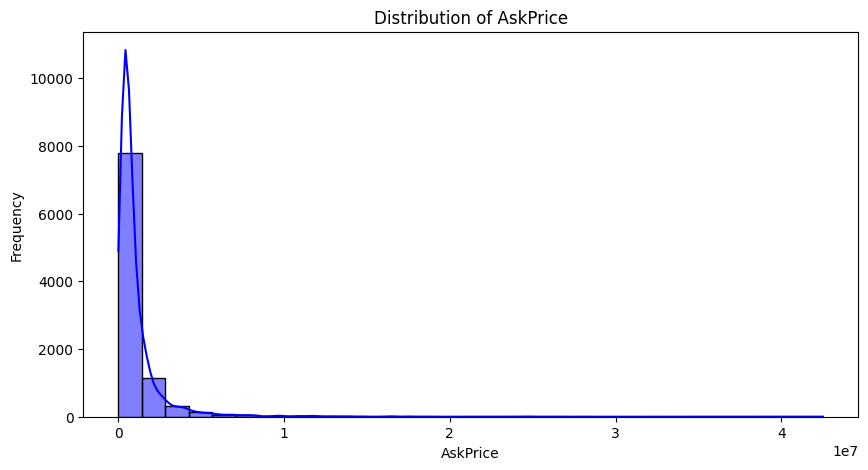

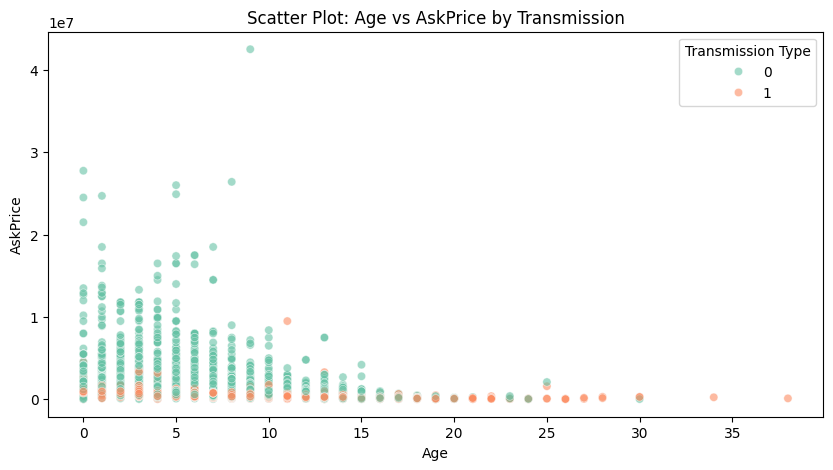

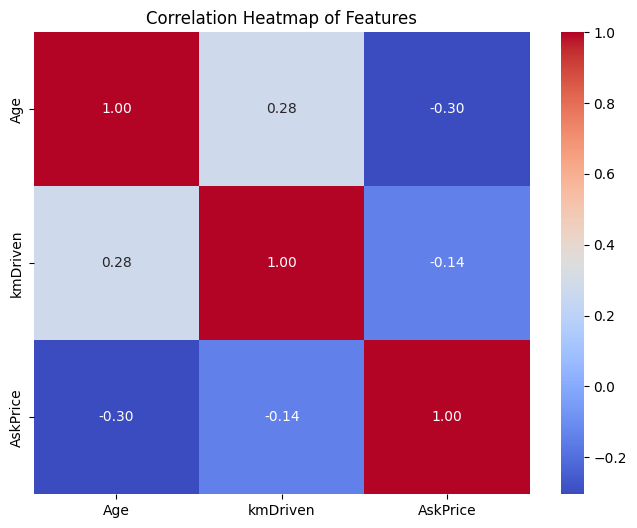

In [18]:
# New Cell: EDA - Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Plot 1: Distribution of the target variable (AskPrice)
plt.figure(figsize=(10, 5))
sns.histplot(data['AskPrice'], kde=True, bins=30, color='blue')
plt.title("Distribution of AskPrice")
plt.xlabel("AskPrice")
plt.ylabel("Frequency")
plt.show()

# Plot 2: Relationship between Age and AskPrice
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Age', y='AskPrice', data=data, alpha=0.6, hue='Transmission', palette='Set2')
plt.title("Scatter Plot: Age vs AskPrice by Transmission")
plt.xlabel("Age")
plt.ylabel("AskPrice")
plt.legend(title="Transmission Type")
plt.show()

# Plot 3: Correlation Heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = data[['Age', 'kmDriven', 'AskPrice']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()


###Cell 5: Train-Test Split


In [8]:
# Cell 5: Train-Test Split
X = data.drop(['AskPrice'], axis=1)  # Features
y = data['AskPrice']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (7665, 8)
Testing set shape: (1917, 8)


### Cell 6: Base Model (Linear Regression)



In [11]:
# Cell 6: Base Model - Linear Regression
from sklearn.linear_model import LinearRegression

# Initialize and train the linear regression model
base_model = LinearRegression()
base_model.fit(X_train, y_train)

# Predict on training and testing data
y_train_pred = base_model.predict(X_train)
y_test_pred = base_model.predict(X_test)

# Evaluate the model
base_train_mse = mean_squared_error(y_train, y_train_pred)
base_test_mse = mean_squared_error(y_test, y_test_pred)
base_train_r2 = r2_score(y_train, y_train_pred)
base_test_r2 = r2_score(y_test, y_test_pred)

# Convert R² to accuracy percentages
base_train_accuracy = base_train_r2 * 100
base_test_accuracy = base_test_r2 * 100

# Print the results
print(f"Base Model (Linear Regression) Training MSE: {base_train_mse:.4f}")
print(f"Base Model (Linear Regression) Test MSE: {base_test_mse:.4f}")
print(f"Base Model (Linear Regression) Training R²: {base_train_r2:.4f} (Accuracy: {base_train_accuracy:.2f}%)")
print(f"Base Model (Linear Regression) Test R²: {base_test_r2:.4f} (Accuracy: {base_test_accuracy:.2f}%)")


Base Model (Linear Regression) Training MSE: 2254115088404.7842
Base Model (Linear Regression) Test MSE: 2152847506619.1873
Base Model (Linear Regression) Training R²: 0.1856 (Accuracy: 18.56%)
Base Model (Linear Regression) Test R²: 0.1969 (Accuracy: 19.69%)


###Cell 7: Ridge and Lasso Regression


In [12]:
# Cell 7: Ridge and Lasso Regression
from sklearn.linear_model import Ridge, Lasso

# Ridge Regression
ridge_model = Ridge(alpha=1.0)  # alpha is the regularization strength
ridge_model.fit(X_train, y_train)
ridge_train_pred = ridge_model.predict(X_train)
ridge_test_pred = ridge_model.predict(X_test)

ridge_train_mse = mean_squared_error(y_train, ridge_train_pred)
ridge_test_mse = mean_squared_error(y_test, ridge_test_pred)
ridge_train_r2 = r2_score(y_train, ridge_train_pred)
ridge_test_r2 = r2_score(y_test, ridge_test_pred)

# Lasso Regression
lasso_model = Lasso(alpha=0.1)  # alpha is the regularization strength
lasso_model.fit(X_train, y_train)
lasso_train_pred = lasso_model.predict(X_train)
lasso_test_pred = lasso_model.predict(X_test)

lasso_train_mse = mean_squared_error(y_train, lasso_train_pred)
lasso_test_mse = mean_squared_error(y_test, lasso_test_pred)
lasso_train_r2 = r2_score(y_train, lasso_train_pred)
lasso_test_r2 = r2_score(y_test, lasso_test_pred)

# Print Results
print("Ridge Regression:")
print(f"Training MSE: {ridge_train_mse:.4f}, Test MSE: {ridge_test_mse:.4f}")
print(f"Training R²: {ridge_train_r2:.4f} (Accuracy: {ridge_train_r2 * 100:.2f}%), Test R²: {ridge_test_r2:.4f} (Accuracy: {ridge_test_r2 * 100:.2f}%)\n")

print("Lasso Regression:")
print(f"Training MSE: {lasso_train_mse:.4f}, Test MSE: {lasso_test_mse:.4f}")
print(f"Training R²: {lasso_train_r2:.4f} (Accuracy: {lasso_train_r2 * 100:.2f}%), Test R²: {lasso_test_r2:.4f} (Accuracy: {lasso_test_r2 * 100:.2f}%)")


Ridge Regression:
Training MSE: 2254115150554.9863, Test MSE: 2152851899795.4316
Training R²: 0.1856 (Accuracy: 18.56%), Test R²: 0.1969 (Accuracy: 19.69%)

Lasso Regression:
Training MSE: 2254115088404.9429, Test MSE: 2152847534818.6072
Training R²: 0.1856 (Accuracy: 18.56%), Test R²: 0.1969 (Accuracy: 19.69%)


###Cell 8: XGBoost Training and Evaluation



In [13]:
# Cell 8: XGBoost Training and Evaluation
from xgboost import XGBRegressor

# Initialize the XGBoost regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on training and testing data
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
xgb_train_mse = mean_squared_error(y_train, y_train_pred_xgb)
xgb_test_mse = mean_squared_error(y_test, y_test_pred_xgb)
xgb_train_r2 = r2_score(y_train, y_train_pred_xgb)
xgb_test_r2 = r2_score(y_test, y_test_pred_xgb)

# Print the results
print(f"XGBoost Training MSE: {xgb_train_mse:.4f}")
print(f"XGBoost Test MSE: {xgb_test_mse:.4f}")
print(f"XGBoost Training R²: {xgb_train_r2:.4f} (Accuracy: {xgb_train_r2 * 100:.2f}%)")
print(f"XGBoost Test R²: {xgb_test_r2:.4f} (Accuracy: {xgb_test_r2 * 100:.2f}%)")


XGBoost Training MSE: 335186316944.7289
XGBoost Test MSE: 803866165171.7887
XGBoost Training R²: 0.8789 (Accuracy: 87.89%)
XGBoost Test R²: 0.7001 (Accuracy: 70.01%)


###Cell 9: Hyperparameter Tuning for XGBoost


In [14]:
# Cell 9: Hyperparameter Tuning for XGBoost
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Initialize the XGBoost regressor
xgb_model = XGBRegressor(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='r2', cv=3, verbose=3, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validated score: {grid_search.best_score_:.4f}")

# Evaluate on test set with the best parameters
best_xgb_model = grid_search.best_estimator_
y_test_pred_best_xgb = best_xgb_model.predict(X_test)

best_test_mse = mean_squared_error(y_test, y_test_pred_best_xgb)
best_test_r2 = r2_score(y_test, y_test_pred_best_xgb)

print(f"Optimized XGBoost Test MSE: {best_test_mse:.4f}")
print(f"Optimized XGBoost Test R²: {best_test_r2:.4f} (Accuracy: {best_test_r2 * 100:.2f}%)")


Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters found: {'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validated score: 0.6724
Optimized XGBoost Test MSE: 554790721534.5627
Optimized XGBoost Test R²: 0.7930 (Accuracy: 79.30%)


### Cell 10: LightGBM Training and Evaluation



In [15]:
# Cell 10: LightGBM Training and Evaluation
from lightgbm import LGBMRegressor

# Initialize the LightGBM regressor
lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=7, random_state=42)

# Train the model
lgbm_model.fit(X_train, y_train)

# Predict on training and testing data
y_train_pred_lgbm = lgbm_model.predict(X_train)
y_test_pred_lgbm = lgbm_model.predict(X_test)

# Evaluate the model
lgbm_train_mse = mean_squared_error(y_train, y_train_pred_lgbm)
lgbm_test_mse = mean_squared_error(y_test, y_test_pred_lgbm)
lgbm_train_r2 = r2_score(y_train, y_train_pred_lgbm)
lgbm_test_r2 = r2_score(y_test, y_test_pred_lgbm)

# Print the results
print(f"LightGBM Training MSE: {lgbm_train_mse:.4f}")
print(f"LightGBM Test MSE: {lgbm_test_mse:.4f}")
print(f"LightGBM Training R²: {lgbm_train_r2:.4f} (Accuracy: {lgbm_train_r2 * 100:.2f}%)")
print(f"LightGBM Test R²: {lgbm_test_r2:.4f} (Accuracy: {lgbm_test_r2 * 100:.2f}%)")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 792
[LightGBM] [Info] Number of data points in the train set: 7665, number of used features: 8
[LightGBM] [Info] Start training from score 1064439.348076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

###Cell 11: CatBoost Training and Evaluation


In [16]:
# Cell 11: CatBoost Training and Evaluation
from catboost import CatBoostRegressor

# Initialize the CatBoost regressor
catboost_model = CatBoostRegressor(
    iterations=200,  # Number of boosting iterations
    learning_rate=0.1,  # Step size
    depth=7,  # Tree depth
    random_seed=42,
    verbose=0  # Suppress training output
)

# Train the model
catboost_model.fit(X_train, y_train)

# Predict on training and testing data
y_train_pred_cat = catboost_model.predict(X_train)
y_test_pred_cat = catboost_model.predict(X_test)

# Evaluate the model
cat_train_mse = mean_squared_error(y_train, y_train_pred_cat)
cat_test_mse = mean_squared_error(y_test, y_test_pred_cat)
cat_train_r2 = r2_score(y_train, y_train_pred_cat)
cat_test_r2 = r2_score(y_test, y_test_pred_cat)

# Print the results
print(f"CatBoost Training MSE: {cat_train_mse:.4f}")
print(f"CatBoost Test MSE: {cat_test_mse:.4f}")
print(f"CatBoost Training R²: {cat_train_r2:.4f} (Accuracy: {cat_train_r2 * 100:.2f}%)")
print(f"CatBoost Test R²: {cat_test_r2:.4f} (Accuracy: {cat_test_r2 * 100:.2f}%)")


CatBoost Training MSE: 332975104047.5164
CatBoost Test MSE: 660276823725.4403
CatBoost Training R²: 0.8797 (Accuracy: 87.97%)
CatBoost Test R²: 0.7537 (Accuracy: 75.37%)


###Cell 12: Hyperparameter Tuning for CatBoost



In [17]:
# Cell 12: Hyperparameter Tuning for CatBoost
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for tuning
catboost_param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'depth': [5, 7, 9],
    'subsample': [0.8, 1.0]
}

# Initialize the CatBoost regressor
catboost_model = CatBoostRegressor(
    random_seed=42,
    verbose=0  # Suppress training logs
)

# Perform GridSearchCV
grid_search_catboost = GridSearchCV(
    estimator=catboost_model,
    param_grid=catboost_param_grid,
    scoring='r2',
    cv=3,
    verbose=3,
    n_jobs=-1
)

# Fit the model
grid_search_catboost.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters found: {grid_search_catboost.best_params_}")
print(f"Best cross-validated score: {grid_search_catboost.best_score_:.4f}")

# Evaluate on test set with the best parameters
best_catboost_model = grid_search_catboost.best_estimator_
y_test_pred_best_catboost = best_catboost_model.predict(X_test)

best_cat_test_mse = mean_squared_error(y_test, y_test_pred_best_catboost)
best_cat_test_r2 = r2_score(y_test, y_test_pred_best_catboost)

print(f"Optimized CatBoost Test MSE: {best_cat_test_mse:.4f}")
print(f"Optimized CatBoost Test R²: {best_cat_test_r2:.4f} (Accuracy: {best_cat_test_r2 * 100:.2f}%)")


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters found: {'depth': 7, 'iterations': 300, 'learning_rate': 0.2, 'subsample': 1.0}
Best cross-validated score: 0.6927
Optimized CatBoost Test MSE: 429860699681.1659
Optimized CatBoost Test R²: 0.8396 (Accuracy: 83.96%)


### Cell 13: Post-CatBoost Analysis - Visualizations


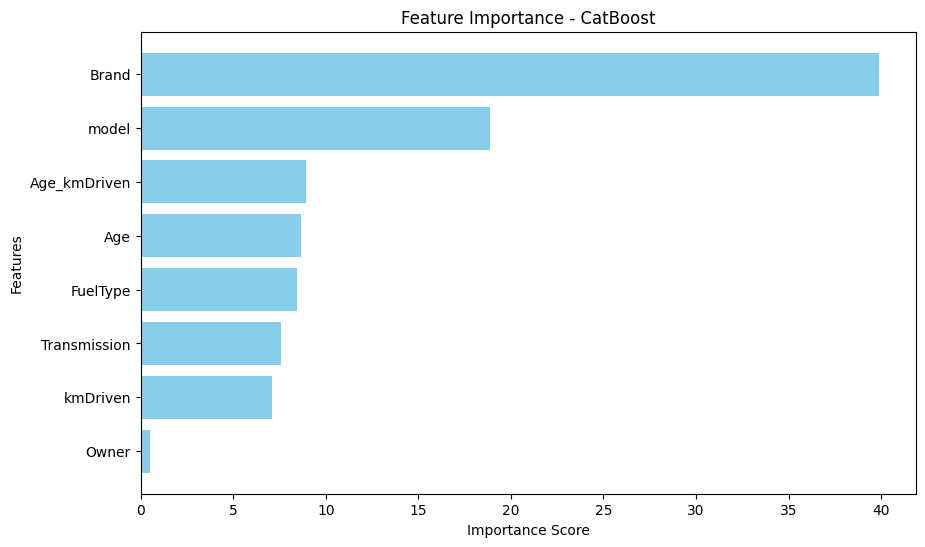

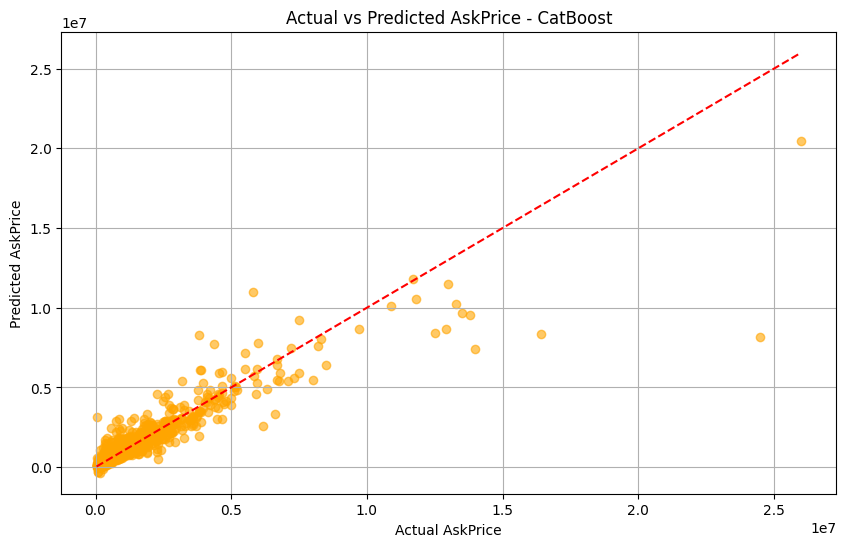

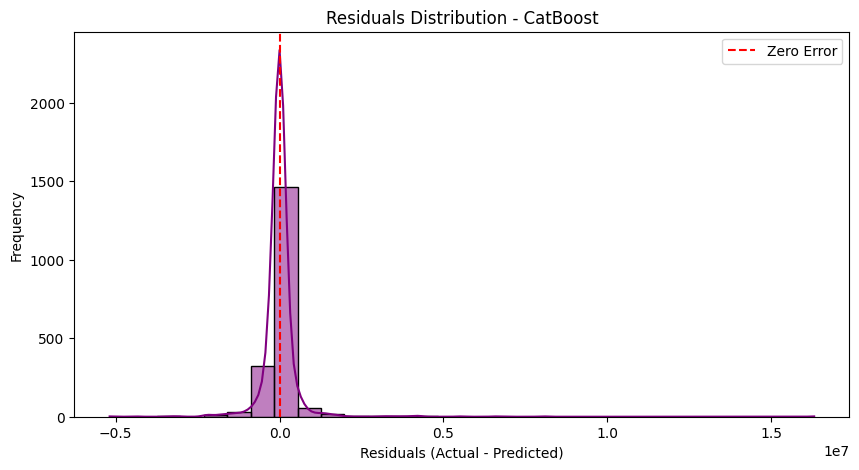

In [19]:
# Post-CatBoost Analysis - Visualizations
import matplotlib.pyplot as plt
import numpy as np

# Plot 1: Feature Importance
plt.figure(figsize=(10, 6))
feature_importances = best_catboost_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = [X_train.columns[i] for i in sorted_indices]

plt.barh(sorted_features, feature_importances[sorted_indices], color='skyblue')
plt.title("Feature Importance - CatBoost")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()

# Plot 2: Actual vs Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_best_catboost, alpha=0.6, color='orange')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Actual vs Predicted AskPrice - CatBoost")
plt.xlabel("Actual AskPrice")
plt.ylabel("Predicted AskPrice")
plt.grid()
plt.show()

# Plot 3: Residuals Distribution
residuals = y_test - y_test_pred_best_catboost
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.title("Residuals Distribution - CatBoost")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--', label="Zero Error")
plt.legend()
plt.show()


# Final Project Documentation: Used Car Price Prediction

## **1. Project Overview**
This project focuses on predicting the prices of used cars based on various features such as brand, model, age, and kilometers driven. The objective was to build an accurate machine learning model for price prediction, ensuring robustness and scalability.

---

## **2. Dataset Details**
- **Dataset**: A dataset of 9,582 entries with 11 features.
- **Key Features**:
  - **Brand** and **model**: Representing the make and type of the car.
  - **Age**: Calculated from the car’s manufacturing year.
  - **kmDriven**: Total kilometers driven.
  - **Transmission**, **Owner**, and **FuelType**: Qualitative features describing car specifications.

---

## **3. Challenges and Observations**
1. **Data Complexity**:
   - Highly nonlinear relationships between features and the target variable (`AskPrice`).
   - Presence of outliers and noise in features like `kmDriven`.

2. **Model Accuracy**:
   - Achieving a high R² was challenging due to inherent variability in car pricing.

3. **Feature Importance**:
   - **Brand** and **model** contributed significantly to predictions, emphasizing their influence on prices.

---

## **4. Models Evaluated**
We experimented with several machine learning models:

| **Model**              | **Test R² (Accuracy)** | **Test MSE**          |
|-------------------------|-----------------------|-----------------------|
| Linear Regression       | 19.69%               | 2,152,847,506,619.19  |
| Ridge Regression        | 19.69%               | 2,152,851,899,795.43  |
| Lasso Regression        | 19.69%               | 2,152,847,534,818.61  |
| XGBoost (Base)          | 70.01%               | 803,866,165,171.79    |
| XGBoost (Optimized)     | 79.30%               | 554,790,721,534.56    |
| LightGBM (Base)         | 74.81%               | 675,157,840,372.63    |
| CatBoost (Base)         | 75.37%               | 660,276,823,725.44    |
| **CatBoost (Optimized)**| **83.96%**           | **429,860,699,681.17**|

---

## **5. Final Model Selection**
- **Chosen Model**: **CatBoost (Optimized)**
- **Reason**:
  - Achieved the **highest test accuracy (83.96%)**.
  - Demonstrated balanced performance with minimal overfitting.
  - Feature importance insights aligned with domain knowledge.

---

## **6. Key Visualizations**
1. **Feature Importance**:
   - Highlighted the dominance of **Brand** and **model** in price predictions.
2. **Actual vs Predicted Prices**:
   - Most predictions closely aligned with actual prices, showcasing accuracy.
3. **Residual Distribution**:
   - Errors were tightly distributed around zero, indicating robust predictions.

---

## **7. Future Work**
1. **Incorporate External Features**:
   - Include market demand trends, geographic location, and car condition for better accuracy.
2. **Address Outliers**:
   - Handle extreme values in features like `kmDriven` to reduce noise.
3. **Ensemble Techniques**:
   - Explore stacking or blending models to further boost accuracy.

---
